# **Ф35**: Модуль прогнозирования эффектов трансформации территории в масштабах населенного пункта и региона

## 1. Подготовка исходных данных

- `service_types` -- таблица типов сервисов.
- `blocks` -- слой городских кварталов с разной информацией.
- `acc_mx` -- матрица доступности городских кварталов.

In [68]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types_df = pd.read_pickle('./data/service_types.pickle')
blocks_gdf = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

In [69]:
blocks_gdf['population'] = blocks_gdf['population'].fillna(0)

### 1.1. Создание колонок

Чтобы не мучаться с передачей всего добра в методы и сразу скушать что надо, можем суммировать нужные колонки по `blocksnet` параметру.

Тогда из наших столбцов получим новые столбцы:
- `count_1` -> `count_park`
- `capacity_1` -> `capacity_park`
- ...
- `count_x` + `count_y` -> `count_z`
- ...

In [70]:
def generate_blocksnet_columns(blocks_gdf : gpd.GeoDataFrame, service_types_df : pd.DataFrame) -> gpd.GeoDataFrame:
    
    from typing import cast

    st_df = service_types_df[~service_types_df.blocksnet.isna()].copy()
    st_df['service_type_id'] = st_df.index
    agg_df = st_df.groupby('blocksnet').agg({'service_type_id': lambda s : list(s)})
    new_columns = {}
    for st_name, row in agg_df.iterrows():
        st_ids = row['service_type_id']
        for prefix in ['count', 'capacity']:
            sum_df = blocks_gdf[[f'{prefix}_{st_id}' for st_id in st_ids]].sum(axis=1)
            new_columns[f'{prefix}_{st_name}'] = sum_df
    new_columns_df = pd.DataFrame.from_dict(new_columns)
    
    df = pd.concat([blocks_gdf, new_columns_df], axis=1)
    return cast(gpd.GeoDataFrame, df)

blocks_gdf = generate_blocksnet_columns(blocks_gdf, service_types_df)

### 1.2. Подготовка списка сервисов

Нужны только те списки сервисов, у которых есть `infrastructure_type` и у которых известно имя `blocksnet`

In [71]:
service_types_df = service_types_df[~service_types_df['infrastructure_type'].isna()].copy()
service_types_df = service_types_df[~service_types_df['blocksnet'].isna()].copy()
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet
service_type_id,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,"[1, 8, 18]",park
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach
21,500.0,basic,0.2,None,7.0,NaN,61.0,[2],kindergarten
22,800.0,basic,0.2,None,15.0,NaN,120.0,"[1, 2, 4]",school
27,5000.0,comfort,0.2,None,60.0,NaN,13.0,"[4, 10, 17]",university


## 2A. Эффекты ДО

Если `scenario_id` является `base_scenario`, то мы не обязаны ничего оптимизировать и просто должны посчитать обеспеченность as is.

In [72]:
from blocksnet.relations.accessibility import get_accessibility_context

def _get_accessibility_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=True)
  return list(context_blocks.index)

In [73]:
from blocksnet.analysis.provision import competitive_provision
from blocksnet.config import service_types_config

def _assess_provision(blocks : pd.DataFrame, acc_mx : pd.DataFrame, service_type : str) -> gpd.GeoDataFrame:
  _, demand, accessibility = service_types_config[service_type].values()
  context_ids = _get_accessibility_context(blocks, acc_mx, accessibility)
  capacity_column = f'capacity_{service_type}'
  if capacity_column not in blocks.columns:
    blocks_df = blocks[['geometry','population']].fillna(0)
    blocks_df['capacity'] = 0
  else:
    blocks_df = blocks.rename(columns={capacity_column:'capacity'})[['geometry', 'population', 'capacity']].fillna(0)
  prov_df, _ = competitive_provision(blocks_df, acc_mx, accessibility, demand)
  prov_df = prov_df.loc[context_ids].copy()
  return blocks[['geometry']].join(prov_df, how='right')

### Получаем слои с оценкой обеспеченности

In [74]:
from blocksnet.config import service_types_config

prov_gdfs = {}
for st_id in service_types_df.index:
    st_name = service_types_df.loc[st_id,'blocksnet']
    column = f'capacity_{st_name}'
    _,demand,accessibility = service_types_config[st_name].values()
    prov_gdf = _assess_provision(blocks_gdf, acc_mx, st_name)
    prov_gdfs[st_name] = prov_gdf

Например:

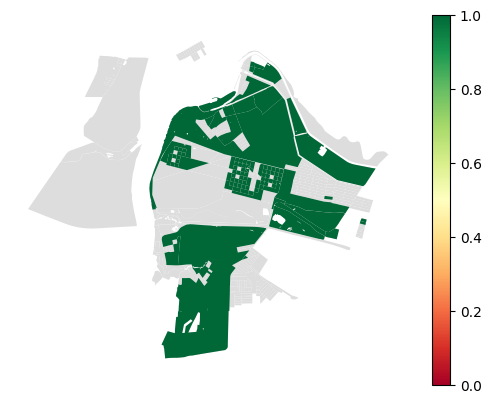

In [75]:
ax = prov_gdfs['park'].plot(color='#ddd')
prov_gdfs['park'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

### Получаем общие оценки обеспеченности

In [76]:
from blocksnet.analysis.provision import provision_strong_total

prov_totals_before = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        if prov_gdf.capacity.sum() > 0:
            total = 1.0
        else:
            total = 0.0
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_before[st_name] = total

В итоге:

In [77]:
prov_totals_before

{'park': 1.0,
 'beach': 0.0,
 'kindergarten': 1.0,
 'school': 0.8116591928251121,
 'university': 0.0,
 'polyclinic': 0.0,
 'pharmacy': 0.20618556701030927,
 'hospital': 0.4430147058823529,
 'library': 0.917910447761194,
 'museum': 0.9961685823754789,
 'theatre': 0.0,
 'cinema': 0.0,
 'mall': 0.628,
 'stadium': 0.2974910394265233,
 'cafe': 0.8703703703703703,
 'restaurant': 0.7422133863485753,
 'bar': 0.7163120567375887,
 'pitch': 0.9983050847457627,
 'playground': 0.0,
 'police': 0.06896551724137931,
 'train_station': 0.46899841017488075,
 'fuel': 0.7315960912052117,
 'supermarket': 0.9360852197070573,
 'market': 0.41729323308270677,
 'post': 0.9019316493313522,
 'bank': 1.0,
 'veterinary': 0.625,
 'hotel': 0.9816176470588235,
 'religion': 0.7216494845360825,
 'sanatorium': 0.0}

### Результат

В результате имеем следующие данные для ситуации ДО:
- `prov_gdfs : dict[str, gpd.GeoDataFrame]` -- слои с оценкой обеспеченности по выбранным типам сервисов
- `prov_totals : dict[str, float | None]` -- оценки обеспеченности

## 2B. Эффекты ПОСЛЕ

Если `scenario_id` не является `base_scenario`, то для заданного пользователем функционального зонирования мы должны предсказать возможную обеспеченность (по сути, лучший случай).

### Подготовка данных

Для каждого `infrastructure_type` также добавим весовой коэффициент, чтобы отдать предпочтение базовым сервисам, а остальные добавлять по возможности.

In [78]:
INFRASTRUCTURES_WEIGHTS = {
    'basic': 0.5714,
    'additional': 0.2857,
    'comfort': 0.1429
}

service_types_df['infrastructure_weight'] = service_types_df['infrastructure_type'].map(INFRASTRUCTURES_WEIGHTS) * service_types_df['weight']
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet,infrastructure_weight
service_type_id,,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,"[1, 8, 18]",park,0.11428
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach,0.07145
21,500.0,basic,0.2,None,7.0,NaN,61.0,[2],kindergarten,0.11428
22,800.0,basic,0.2,None,15.0,NaN,120.0,"[1, 2, 4]",school,0.11428
27,5000.0,comfort,0.2,None,60.0,NaN,13.0,"[4, 10, 17]",university,0.02858


Готовим словарь, какой квартал в какой ФЗ переводим.

`blocks_lus : dict[int, LandUse]`

In [79]:
from blocksnet.enums import LandUse

blocks_lus = blocks_gdf.loc[blocks_gdf['is_project'],'land_use']
blocks_lus = blocks_lus[~blocks_lus.isna()]
blocks_lus = blocks_lus.to_dict()
# blocks_lus[0] = LandUse.RESIDENTIAL #FIXME УДАЛИТЬ!!! ЭТО ДЛЯ ПРИМЕРА

Инициализируем экземпляр класса оптимизатора.

In [80]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    GradientChooser,
    AreaSolution
)

var_adapter = AreaSolution(blocks_lus)

facade = Facade(
    blocks_lu=blocks_lus,
    blocks_df=blocks_gdf,
    accessibility_matrix=acc_mx,
    var_adapter=var_adapter,
)


Добавляем информацию о существующих типах сервисов.

**ВАЖНО**: если сервиса нет в слое кварталов, просто добавляем `DataFrame` с нулевыми `capacity` для него. Ведь мы же должны что-то расставлять.

ЛИБО

Можно попробовать на этапе сборки слоя просто добавлять пустой столбец, чтобы не терять.

In [81]:
for st_id, row in service_types_df.iterrows():
    st_name = row['blocksnet']
    st_weight = row['infrastructure_weight']
    st_column = f'capacity_{st_name}'
    df = blocks_gdf.rename(columns={st_column: 'capacity'})[['capacity']].fillna(0)
    facade.add_service_type(st_name, st_weight, df)

### Оптимизация

Запускаем оптимизатор...

In [82]:
MAX_EVALS = 1000 # сколько раз будет считаться обеспеченность. Можно ставить и большее число, если ориентируемся только на время
MAX_RUNS = 1000 # сколько итераций будет считаться в оптимизации. Так же ставим 1000 без проблем
TIMEOUT = 1 * 60 # сколько по времени будет считаться оптимизация (в секундах). Если уже прошло данное время, досчитается итерация и отдаст ответ

In [83]:
services_weights = service_types_df.set_index('blocksnet')['infrastructure_weight'].to_dict()

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=services_weights, max_evals=MAX_EVALS)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=GradientChooser(facade, facade.num_params, num_top=5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=MAX_RUNS, timeout=TIMEOUT, initial_runs_num=1)

[I 2025-12-19 16:37:46,505] A new study created in memory with name: no-name-1da09519-ea5d-4f85-884e-e7f9b5d64f5d


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-12-19 16:38:29,560] Trial 0 finished with value: 2.5168047999744356 and parameters: {'x_0': 12000, 'x_1': 12000, 'x_2': 12000, 'x_3': 12000, 'x_4': 12000, 'x_5': 12000, 'x_6': 12000, 'x_7': 12000, 'x_8': 12000, 'x_9': 12000, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_13': 1440, 'x_14': 1440, 'x_15': 1440, 'x_16': 1440, 'x_17': 1440, 'x_18': 1440, 'x_19': 1440, 'x_20': 1440, 'x_21': 1440, 'x_22': 1440, 'x_23': 1440, 'x_24': 0, 'x_25': 1440, 'x_26': 3520, 'x_27': 3520, 'x_28': 3520, 'x_29': 3520, 'x_30': 3520, 'x_31': 3520, 'x_32': 3520, 'x_33': 3520, 'x_34': 3520, 'x_35': 3520, 'x_36': 3520, 'x_37': 3520, 'x_38': 3520, 'x_39': 3520, 'x_40': 3520, 'x_41': 3520, 'x_42': 3520, 'x_43': 3520, 'x_44': 3520, 'x_45': 3520, 'x_46': 3520, 'x_47': 3520, 'x_48': 3520, 'x_49': 3520, 'x_50': 3520, 'x_51': 3520, 'x_52': 3520, 'x_53': 3520, 'x_54': 3520, 'x_55': 3520, 'x_56': 3520, 'x_57': 3520, 'x_58': 3520, 'x_59': 3520, 'x_60': 0, 'x_61': 3520, 'x_62': 3520, 'x_63': 3520, 'x_64': 3520, 'x_65': 3520

### Результат

Во-первых, обнуляем для территории все `capacity_`, `count_` и `population`, чтобы Ф22 был адекватен

In [84]:
columns = [c for c in blocks_gdf.columns if 'capacity_' in c or 'count_' in c or 'population' in c]
blocks_gdf.loc[blocks_gdf.is_project, columns] = 0

Обновляем параметры кварталов согласно тому, что наоптимизировали

In [85]:
def get_solution_df(solution):
    units_df = facade.solution_to_services_df(solution)
    population_df = facade.get_solution_area_df(solution).loc[list(facade._blocks_lu.keys())]

    df = (
        units_df
        .groupby(['block_id', 'service_type'])
        .agg({'capacity': 'sum', 'count': 'sum'})
        .unstack('service_type')  # превращаем service_type в столбцы
    )
    columns = []

    for col in df.columns:
        name = col[0]
        st_name = col[1]
        column = f'{name}_{st_name}'
        columns.append(column)
    df.columns = columns

    df.loc[population_df.index, 'population'] = population_df['population']

    return df.fillna(0)

solution_df = get_solution_df(best_x)
blocks_gdf.loc[solution_df.index, solution_df.columns] += solution_df

## Пересчитываем обеспеченности

In [86]:
from blocksnet.config import service_types_config

prov_gdfs = {}
for st_id in service_types_df.index:
    st_name = service_types_df.loc[st_id,'blocksnet']
    column = f'capacity_{st_name}'
    _,demand,accessibility = service_types_config[st_name].values()
    prov_gdf = _assess_provision(blocks_gdf, acc_mx, st_name)
    prov_gdfs[st_name] = prov_gdf

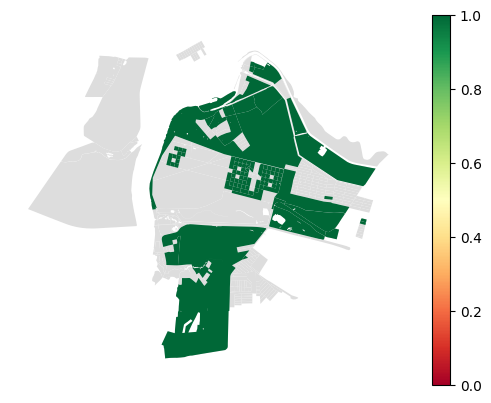

In [87]:
st_test = 'park'

ax = prov_gdfs[st_test].plot(color='#ddd')
prov_gdfs[st_test].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

Чиселки обеспеченности для графика

In [88]:
prov_totals_after = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        if prov_gdf.capacity.sum() > 0:
            total = 1.0
        else:
            total = 0.0
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_after[st_name] = total

Если какой-то сервис тут отсутствует, можно брать с `base_scenario` (?? я подумаю еще правильно ли это)

In [89]:
prov_totals_after

{'park': 1.0,
 'beach': 0.9948898115618013,
 'kindergarten': 1.0,
 'school': 1.0,
 'university': 0.9962490622655664,
 'polyclinic': 1.0,
 'pharmacy': 1.0,
 'hospital': 0.9624463519313304,
 'library': 1.0,
 'museum': 1.0,
 'theatre': 0.9953917050691244,
 'cinema': 0.9953917050691244,
 'mall': 1.0,
 'stadium': 1.0,
 'cafe': 1.0,
 'restaurant': 0.9443990188062142,
 'bar': 0.9991708126036484,
 'pitch': 1.0,
 'playground': 1.0,
 'police': 1.0,
 'train_station': 1.0,
 'fuel': 0.9227891156462585,
 'supermarket': 0.9949750780078616,
 'market': 0.9451710261569416,
 'post': 1.0,
 'bank': 1.0,
 'veterinary': 0.9548872180451128,
 'hotel': 1.0,
 'religion': 0.9460916442048517,
 'sanatorium': 0.9759846301633045}

<Axes: >

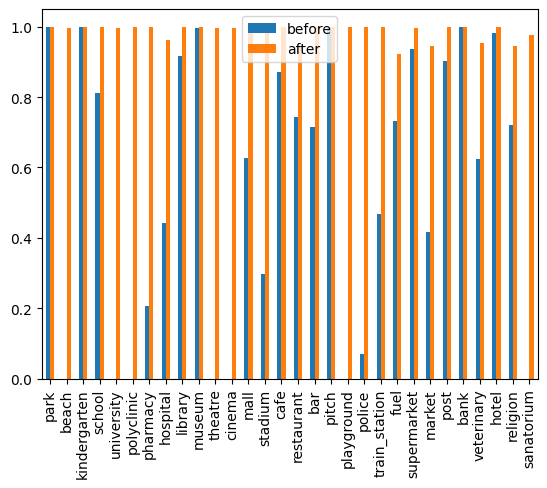

In [90]:
provisions_df = pd.DataFrame.from_dict({'before': prov_totals_before, 'after': prov_totals_after})
provisions_df.plot.bar()

## Выход в другие модули

Чтоб могли посчитать и сопоставить

In [91]:
blocks_gdf.to_pickle('./data/blocks_f35.pickle')

# **Ф26**: Модуль ценностно-ориентированного моделирования программ развития населенного пункта.

Берем результат из пункта `2.b` и разворачиваем его на кварталы: куда что ставить:

- `block_id` -- номер квартала, куда ставим.
- `service_type` -- тип сервиса.
- `site_area` -- занимаемая площадь квартала.
- `build_floor_area` -- занимаемая площадь зданий.
- `capacity` -- суммарная емкость типа застройки
- `count` -- количество расставляемых объектов данного типа в данном квартале

In [92]:
units_df = facade.solution_to_services_df(best_x)
units_df

,block_id,service_type,site_area,build_floor_area,capacity,count
0,1,park,12000.0,0.0,1200,1
5,3,park,12000.0,0.0,1200,1
10,8,park,12000.0,0.0,1200,1
15,9,park,12000.0,0.0,1200,1
20,10,park,12000.0,0.0,1200,1
...,...,...,...,...,...,...
11222,9,sanatorium,25000.0,7500.0,250,1
11225,10,sanatorium,25000.0,7500.0,250,1
11231,13,sanatorium,25000.0,7500.0,250,1
11234,18,sanatorium,25000.0,7500.0,250,1


Отсюда нужно взять `population` для каждого квартала (`index` здесь это тот же индекс из `blocks : pd.DataFrame`)

In [93]:
solution_population_df = facade.get_solution_area_df(best_x)
solution_population_df

,population,build_floor_area,living_area,footprint_area
0,11568.0,162647.279348,123945.279348,28915.071884
1,0.0,19482.700499,0.000000,0.000000
2,2304.0,32625.525069,24693.525069,5800.093346
3,0.0,311966.928390,0.000000,0.000000
4,1160.0,22158.105588,12436.105588,3939.218771
...,...,...,...,...
3476,0.0,431.392326,0.000000,0.000000
3477,0.0,30.325341,0.000000,0.000000
3478,0.0,388.288396,0.000000,0.000000
3479,0.0,454.526244,0.000000,0.000000
